# Solar Wind investigation + Classification algorithm

In [4]:
import pandas as pd
import matplotlib.pyplot as plt    

## Data Cleaning and exploration

In [5]:
df = pd.read_csv('solar_wind.csv')
df.head()

,period,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source
0,train_a,0 days 00:00:00,-5.55,3.00,1.25,11.09,153.37,-5.55,3.00,1.25,11.09,153.37,6.80,1.53,383.92,110237.0,ac
1,train_a,0 days 00:01:00,-5.58,3.16,1.17,10.10,151.91,-5.58,3.16,1.17,10.10,151.91,6.83,1.69,381.79,123825.0,ac
2,train_a,0 days 00:02:00,-5.15,3.66,0.85,7.87,146.04,-5.15,3.66,0.85,7.87,146.04,6.77,1.97,389.11,82548.0,ac
3,train_a,0 days 00:03:00,-5.20,3.68,0.68,6.17,146.17,-5.20,3.68,0.68,6.17,146.17,6.74,1.97,389.11,82548.0,ac
4,train_a,0 days 00:04:00,-5.12,3.68,0.49,4.62,145.72,-5.12,3.68,0.49,4.62,145.72,6.65,1.77,384.26,94269.0,ac


In [6]:
df.drop([
    'bx_gsm',
    'by_gsm',
    'bz_gsm',
    'density',
    'source',
    'temperature',
    'phi_gsm',
    'theta_gse',
    'phi_gse',
    'theta_gsm',
    'bt',
    'speed'],errors='ignore', axis=1, inplace=True)

In [7]:
df.shape


(8392320, 5)

In [8]:
train_a = df.loc[df['period'] == 'train_a']
train_a.shape

(1729440, 5)

### Drop missing values

In [9]:
clean_train_a = train_a.dropna()

In [10]:
train_a = df.loc[df['period'] == 'train_a']
train_a['bx_gse'].max()


np.float64(41.13)

In [11]:
standard_deviation = train_a['bx_gse'].std()
lower_threshold = standard_deviation * -3
higher_threshold = standard_deviation * 3
lower_threshold

np.float64(-13.017637037916273)

Interquartile Range

In [12]:
higher_q = clean_train_a['bx_gse'].quantile(0.75)
lower_q = clean_train_a['bx_gse'].quantile(0.25)
iqr = higher_q - lower_q

In [13]:
higher_q + (1.5 * iqr)

np.float64(11.315000000000001)

In [14]:
clean_train_a['Irregular_Activity'] = (clean_train_a['bx_gse'] > higher_q + (1.5*iqr) ) | (clean_train_a['bx_gse'] < lower_q - (1.5 * iqr) )
clean_train_a.loc[clean_train_a['Irregular_Activity'] == True, ['bx_gse']]

,bx_gse
7244,11.86
7245,14.80
7251,12.92
7287,11.73
7293,19.03
...,...
1716741,-15.24
1716742,-15.21
1716743,-15.19
1716744,-15.27


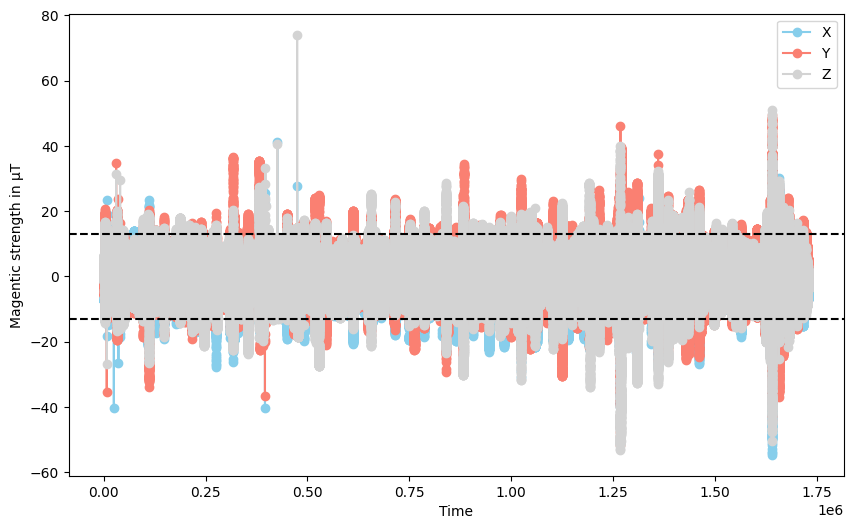

In [15]:
fig, ax = plt.subplots(figsize=(10,6))


ax.plot(clean_train_a.index, clean_train_a['bx_gse'], color= 'skyblue', marker = 'o', label='X')
ax.plot(clean_train_a.index, clean_train_a['by_gse'], color='salmon', marker='o', label='Y')
ax.plot(clean_train_a.index, clean_train_a['bz_gse'], color = 'lightgray', marker='o', label='Z')

ax.axhline(y=higher_threshold, color='black', linestyle='dashed')
ax.axhline(y=lower_threshold, color='black', linestyle = 'dashed')


ax.set_xlabel('Time')
ax.set_ylabel('Magentic strength in μT')


ax.legend()
plt.savefig('plot.png')


### Feature Engineering

In [16]:
clean_train_a['filtered_x'] = clean_train_a['bx_gse']

In [17]:
filtered_train_a = clean_train_a.dropna()
filtered_train_a.shape

(1575012, 7)

In [18]:
filtered_train_a.loc[filtered_train_a['Irregular_Activity'] == True]

,period,timedelta,bx_gse,by_gse,bz_gse,Irregular_Activity,filtered_x
7244,train_a,5 days 00:44:00,11.86,-10.58,-2.53,True,11.86
7245,train_a,5 days 00:45:00,14.80,-2.96,-0.72,True,14.80
7251,train_a,5 days 00:51:00,12.92,6.00,-0.21,True,12.92
7287,train_a,5 days 01:27:00,11.73,-4.60,0.22,True,11.73
7293,train_a,5 days 01:33:00,19.03,-7.17,6.86,True,19.03
...,...,...,...,...,...,...,...
1716741,train_a,1192 days 04:21:00,-15.24,8.44,-10.02,True,-15.24
1716742,train_a,1192 days 04:22:00,-15.21,8.25,-9.89,True,-15.21
1716743,train_a,1192 days 04:23:00,-15.19,8.48,-9.85,True,-15.19
1716744,train_a,1192 days 04:24:00,-15.27,8.70,-9.72,True,-15.27


In [19]:
filtered_train_a['Magnitude'] = ((filtered_train_a['bx_gse']**2) + (filtered_train_a['by_gse'] ** 2) + (filtered_train_a['bz_gse'] ** 2)) ** 0.5
filtered_train_a.head()

,period,timedelta,bx_gse,by_gse,bz_gse,Irregular_Activity,filtered_x,Magnitude
0,train_a,0 days 00:00:00,-5.55,3.00,1.25,False,-5.55,6.431563
1,train_a,0 days 00:01:00,-5.58,3.16,1.17,False,-5.58,6.518504
2,train_a,0 days 00:02:00,-5.15,3.66,0.85,False,-5.15,6.374998
3,train_a,0 days 00:03:00,-5.20,3.68,0.68,False,-5.20,6.406622
4,train_a,0 days 00:04:00,-5.12,3.68,0.49,False,-5.12,6.324310


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

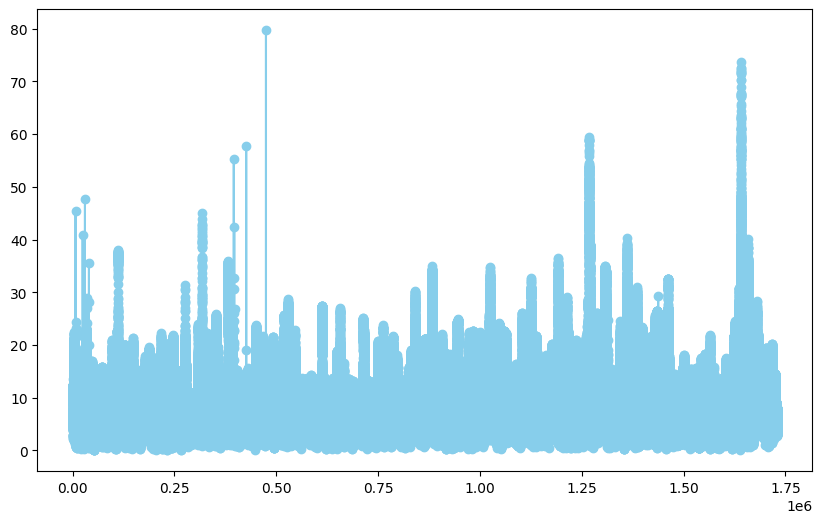

In [20]:
fig, ax = plt.subplots(figsize=(10,6))

mag_high_thresh = 3 * filtered_train_a['Magnitude'] 


ax.plot(filtered_train_a.index, filtered_train_a['Magnitude'], color= 'skyblue', marker = 'o', label='X')

ax.axhline(y=mag_high_thresh, color='black', linestyle='dashed')



ax.set_xlabel('Time')
ax.set_ylabel('Magentic strength in μT')


ax.legend()
plt.savefig('plot.png')

# Main dataset - Logistic Regression Training

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

In [22]:
filtered_train_a.head()

,period,timedelta,bx_gse,by_gse,bz_gse,Irregular_Activity,filtered_x,Magnitude
0,train_a,0 days 00:00:00,-5.55,3.00,1.25,False,-5.55,6.431563
1,train_a,0 days 00:01:00,-5.58,3.16,1.17,False,-5.58,6.518504
2,train_a,0 days 00:02:00,-5.15,3.66,0.85,False,-5.15,6.374998
3,train_a,0 days 00:03:00,-5.20,3.68,0.68,False,-5.20,6.406622
4,train_a,0 days 00:04:00,-5.12,3.68,0.49,False,-5.12,6.324310


In [23]:
main_dataset = filtered_train_a.drop(['period', 'bx_gse'], axis=1)
main_dataset = main_dataset.dropna()

In [24]:
main_dataset['filtered_x'].max()

np.float64(41.13)

## Data Preprocesing

In [25]:
def duration_to_minutes(duration_str):
    days_part, time_part = duration_str.split(" days ")
    days = int(days_part)
    hours, minutes, seconds = map(int, time_part.split(":"))
    return days * 24 * 60 + hours * 60 + minutes + seconds // 60


main_dataset['minutes'] = df['timedelta'].apply(duration_to_minutes)
main_dataset = main_dataset.drop(['timedelta'], axis=1)
main_dataset.head()



,by_gse,bz_gse,Irregular_Activity,filtered_x,Magnitude,minutes
0,3.00,1.25,False,-5.55,6.431563,0
1,3.16,1.17,False,-5.58,6.518504,1
2,3.66,0.85,False,-5.15,6.374998,2
3,3.68,0.68,False,-5.20,6.406622,3
4,3.68,0.49,False,-5.12,6.324310,4


In [26]:
main_dataset.head()

,by_gse,bz_gse,Irregular_Activity,filtered_x,Magnitude,minutes
0,3.00,1.25,False,-5.55,6.431563,0
1,3.16,1.17,False,-5.58,6.518504,1
2,3.66,0.85,False,-5.15,6.374998,2
3,3.68,0.68,False,-5.20,6.406622,3
4,3.68,0.49,False,-5.12,6.324310,4


In [27]:
X = main_dataset[['filtered_x', 'Magnitude', 'minutes', 'by_gse', 'bz_gse']]
y = main_dataset['Irregular_Activity']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Verifying to check mean is 0 and std deviation is 0

In [30]:
print("Mean of scaled training data:", np.mean(X_train_scaled, axis=0))
print("Standard deviation of scaled training data:", np.std(X_train_scaled, axis=0))

Mean of scaled training data: [-4.78541475e-17 -4.04713229e-16 -4.20683409e-18  2.24496066e-17
  1.57107772e-17]
Standard deviation of scaled training data: [1. 1. 1. 1. 1.]


In [31]:
model = LogisticRegression(class_weight={0:1, 1:8}, random_state=42)
model.fit(X_train_scaled, y_train)
wind_prediction = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, wind_prediction))
print("Classification Report:\n", classification_report(y_test, wind_prediction))

Accuracy: 0.9888413761138782
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.99      0.99    313096
        True       0.31      0.67      0.42      1907

    accuracy                           0.99    315003
   macro avg       0.65      0.83      0.71    315003
weighted avg       0.99      0.99      0.99    315003



Support indicates that there is a massive imbalance between the False and True class. I will visualise a pie chart to show ~

Text(0.5, 1.0, 'Imbalance of data between True and False values')

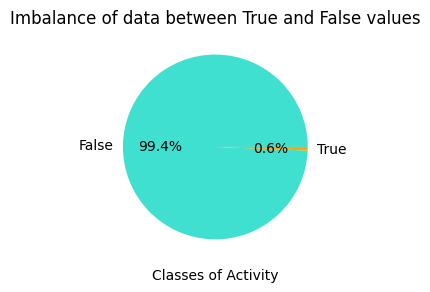

In [32]:
fig, ax = plt.subplots(figsize=(5,3))
true_or_false = main_dataset['Irregular_Activity'].value_counts().reset_index()
labels = ['False', 'True']
ax.pie(true_or_false['count'], labels=labels, colors=['turquoise', 'orange'], autopct='%1.1f%%')
ax.set_xlabel('Classes of Activity')

ax.set_title('Imbalance of data between True and False values')

My solution I will try to implement is downscaling (Removing False data so ratio of False to True is equal)

In [33]:
X = main_dataset[['filtered_x', 'Magnitude', 'minutes', 'by_gse', 'bz_gse']]
y = main_dataset['Irregular_Activity']

Text(0.5, 1.0, 'Imbalance of data between True and False values')

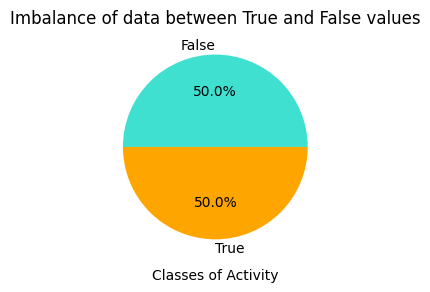

In [34]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(sampling_strategy=1)

X_resize, y_resize = under_sampler.fit_resample(X, y)

fig, ax = plt.subplots(figsize=(5,3))
true_or_false = y_resize.value_counts().reset_index()
ax.pie(true_or_false['count'], labels=labels, colors=['turquoise', 'orange'], autopct='%1.1f%%')
ax.set_xlabel('Classes of Activity')

ax.set_title('Imbalance of data between True and False values')

Now that the proportions are the same, we can test the model again

In [35]:

X_train, X_test, y_train, y_test = train_test_split(X_resize, y_resize, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(class_weight={0:1, 1:8}, random_state=42)
model.fit(X_train_scaled, y_train)

wind_prediction = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, wind_prediction))
print("Classification Report:\n", classification_report(y_test, wind_prediction))

Accuracy: 0.9683234612413083
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.94      0.97      1957
        True       0.94      1.00      0.97      1926

    accuracy                           0.97      3883
   macro avg       0.97      0.97      0.97      3883
weighted avg       0.97      0.97      0.97      3883



In [36]:
import pickle

with open('model.csv','wb') as f:
    pickle.dump(model, f)